In [15]:
import xarray as xr
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.stats import linregress
from matplotlib.colors import LogNorm
import cmocean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

settings = json.load(open('../plot_settings.json'))
plt.rcParams.update(settings)

In [16]:
path = '/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/simulation/sim_out/'
files = [os.path.join(path, f) for f in os.listdir(path) if 'MODIS_SST' in f]
files.sort()

ds = xr.concat([xr.open_dataset(f) for f in files], dim='time')


In [17]:
BT1 = ds['BT'].isel(channel=0) - 273.15
BT2 = ds['BT'].isel(channel=1) - 273.15
BT3 = ds['BT'].isel(channel=2) - 273.15
BT5 = ds['BT'].isel(channel=3) - 273.15
BT6 = ds['BT'].isel(channel=4) - 273.15

skinT = ds['MODIS_skin_T'] - 273.15

nanmask = ~np.isnan(BT5) & ~np.isnan(skinT)
BT5 = BT5[nanmask]
skinT = skinT[nanmask]



In [18]:
iwv_path  = '../../../MasterArbeit/Simulations/different_IWV'
files = [os.path.join(iwv_path, f) for f in os.listdir(iwv_path) if 'VELOX' in f]
days = np.unique([files[i].split('/')[-1].split('_')[1] for i in range(len(files))])

list_of_ds = []

for day in days:

    files = [os.path.join(iwv_path, f) for f in os.listdir(iwv_path) if day in f]
    files.sort()

    ### sort by last number in filename

    files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    print(files)
    ds = xr.concat([xr.open_dataset(f) for f in files], dim='IWV')
    list_of_ds.append(ds)

ds_iwv = xr.concat(list_of_ds, dim='time')
ds_iwv['IWV'] = np.arange(0, 50, 1)


fit_dict = {
    'R2' : [],
    'RMSE' : [],
    'method' : [],
}

for i, iwv in enumerate(ds_iwv.IWV):

    BT5 = ds_iwv['BT'].isel(channel=2).sel(IWV=iwv)
    BT6 = ds_iwv['BT'].isel(channel=4).sel(IWV=iwv)

    y = ds_iwv['MODIS_skin_T'].sel(IWV=iwv)

    nanmask = ~np.isnan(BT5) & ~np.isnan(BT6) & ~np.isnan(y)

    BT5 = BT5[nanmask]
    BT6 = BT6[nanmask]
    y = y[nanmask]

    X = np.stack([BT5, BT6], axis=1)

    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    fit_dict['R2'].append(r2)
    fit_dict['RMSE'].append(rmse)
    fit_dict['method'].append('split-window')

    X = BT5.values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    fit_dict['R2'].append(r2)
    fit_dict['RMSE'].append(rmse)
    fit_dict['method'].append('single-channel')

df_fit = pd.DataFrame(fit_dict) 


sc = list(df_fit.groupby('method'))[0][1]
sw= list(df_fit.groupby('method'))[1][1]

sc['IWV'] = ds_iwv.IWV.values
sw['IWV'] = ds_iwv.IWV.values

sc.set_index('IWV', inplace=True)
sw.set_index('IWV', inplace=True)

e_vel_sys_b5 = 0.82
e_vel_sys_b6 = 0.72


e5 = (.47**2 + .473**2)**.5
e6 = (.47**2 + .442**2)**.5

print(f'e5 = {e5}, e6 = {e6}')

et = np.sqrt(e5**2 + e6**2)

print(f'et = {et}')

sc['e_tot'] = (sc['RMSE']**2 + e5**2 + e_vel_sys_b5**2)**.5
sw['e_tot'] = (sw['RMSE']**2 + e5**2 + e6**2 + e_vel_sys_b6**2 + e_vel_sys_b5)**.5

['../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_0.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_1.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_2.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_3.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_4.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_5.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_6.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_7.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_8.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_9.nc', '../../../MasterArbeit/Simulations/different_IWV/VELOX_20220312_60s_zout_HALO_IWV_10.nc', '../../../MasterArb

<>:28: SyntaxWarning: invalid escape sequence '\,'
<>:28: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_233598/851848453.py:28: SyntaxWarning: invalid escape sequence '\,'
  ax.set_xlabel('IWV (kg$\,$m$^{-2}$)')


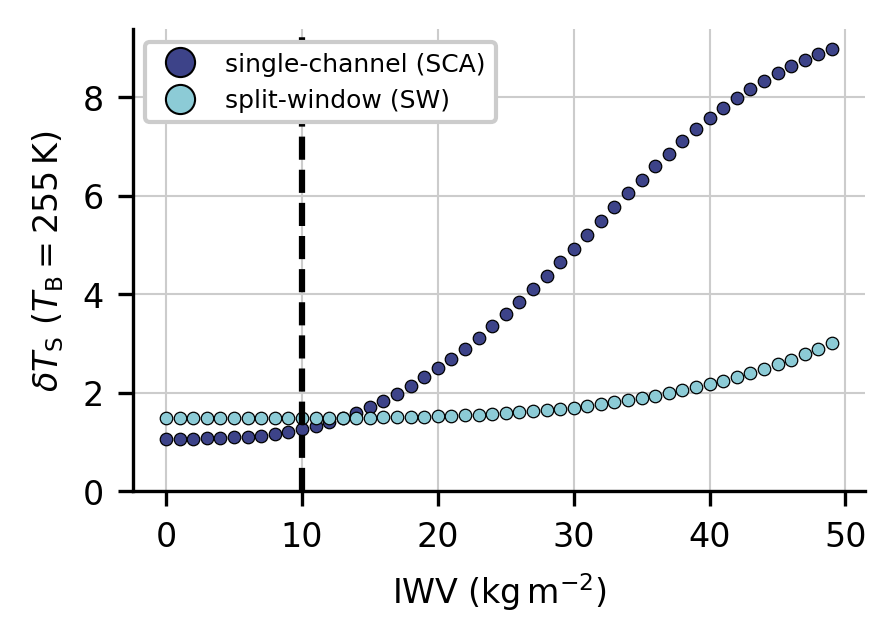

In [20]:
import cmocean
fig, ax = plt.subplots(1, 1, figsize=(3.15, 2))

colors = plt.get_cmap('Dark2')
colors = cmocean.cm.ice

plt.rcParams.update({'ytick.labelsize': 8, 'xtick.labelsize': 8, 'axes.labelsize': 8})
plt.rcParams.update({'font.size': 8})

c1 = colors(.3)
c2 = colors(.8)

sc['e_tot'].plot(ax=ax, label='single-channel', lw=0, ms=3, marker='o', color=c1, markeredgewidth=0.3, markeredgecolor='k')
sw['e_tot'].plot(ax=ax, label='split-window', lw=0, ms=3, marker='o', color=c2, markeredgewidth=0.3, markeredgecolor='k')

ax.axvline(10, color='k', lw=1.5, linestyle='--')

## make the legend mnaually

handles = [plt.Line2D([0], [0], marker='o', color='w', label='single-channel (SCA)', markerfacecolor=c1, markersize=7, markeredgecolor='k', markeredgewidth=.5),
           plt.Line2D([0], [0], marker='o', color='w', label='split-window (SW)', markerfacecolor=c2, markersize=7, markeredgecolor='k', markeredgewidth=.5)]

ax.legend(handles=handles, loc='upper left', fontsize=6, framealpha=1.0)

ax.set_ylabel(r'$\delta T_\mathrm{S}$ ($T_\mathrm{B}=255\,$K)')
ax.set_yticks(np.arange(0,10,2))
ax.set_xticks(np.arange(0, 55, 10))
ax.set_xlabel('IWV (kg$\,$m$^{-2}$)')

ax.spines[['top', 'right']].set_visible(False)

plt.savefig('../../plots/publish/figure03.png', dpi=300, bbox_inches='tight')

